# WiFi Signal Strength Analysis for Indoor Localization
This project analyzes WiFi RSSI data to determine if WiFi can be used for indoor positioning.

Load Libraries (Code Cell)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

Load and Process WiFi Data

In [2]:
# Define folder path for WiFi scan files
folder_path = "../data"

# Ensure the results directory exists
results_folder = "../results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Dictionary to store MAC → SSID mapping (since JSON format lacks SSID)
mac_to_ssid = {}

# Initialize an empty list to store processed data
wifi_data = []

# Function to process WiFi text files
def process_wifi_file(file_path, location_name):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    scan_id = 0  # Differentiate 10 scans per location
    seen_macs = set()  # Store seen MAC addresses per scan to avoid duplicates

    for line in lines:
        # Extract MAC Address, RSSI, SSID from comma-separated format
        csv_match = re.search(r'(\d+),\d+,(-?\d+),.*?,.*?,.*?,.*?,([\dA-Fa-f:]+),(.+)', line)

        # Extract MAC Address and RSSI from JSON format (which lacks SSID)
        json_match = re.search(r'{"macAddress": "([\dA-Fa-f:]+)",\s*"signalStrength": (-?\d+),', line)

        # Extract timestamp if available
        time_match = re.search(r'(\d{2}:\d{2}:\d{2})', line)

        # If we find a valid comma-separated line with SSID
        if csv_match:
            mac_address = csv_match.group(3)
            rssi = int(csv_match.group(2))
            ssid = csv_match.group(4).strip()  # Extract SSID

            # Store MAC to SSID mapping (for JSON entries later)
            mac_to_ssid[mac_address] = ssid  

            # Ensure MAC is counted only once per scan
            if mac_address not in seen_macs:
                seen_macs.add(mac_address)
                timestamp = time_match.group(1) if time_match else datetime.datetime.now().strftime("%H:%M:%S")
                wifi_data.append([location_name, scan_id, mac_address, rssi, ssid, timestamp])

        # If we find a JSON-style entry (missing SSID), use stored mapping
        elif json_match:
            mac_address = json_match.group(1)
            rssi = int(json_match.group(2))
            ssid = mac_to_ssid.get(mac_address, "Unknown")  # Retrieve SSID from previous entries

            # Ensure MAC is counted only once per scan
            if mac_address not in seen_macs:
                seen_macs.add(mac_address)
                timestamp = time_match.group(1) if time_match else datetime.datetime.now().strftime("%H:%M:%S")
                wifi_data.append([location_name, scan_id, mac_address, rssi, ssid, timestamp])

        if "We should be done now" in line:
            scan_id += 1  # Move to next scan
            seen_macs.clear()  # Reset seen MAC addresses for the new scan

# Process all text files in the data folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        location_name = filename.replace(".txt", "")  # Extract location name
        process_wifi_file(os.path.join(folder_path, filename), location_name)

# Convert to Pandas DataFrame
df = pd.DataFrame(wifi_data, columns=["Location", "Scan_ID", "MAC_Address", "RSSI", "SSID", "Timestamp"])

# Save to CSV for easy access
csv_path = os.path.join(results_folder, "combined_wifi_data.csv")
df.to_csv(csv_path, index=False)

# Display first few rows
print("Processed Data Saved to:", csv_path)
df.head()

Processed Data Saved to: ../results/combined_wifi_data.csv


,Location,Scan_ID,MAC_Address,RSSI,SSID,Timestamp
0,GBlock_1F_Washroom,0,84:d4:7e:e6:24:c0,-56,airuc-guest,13:02:27
1,GBlock_1F_Washroom,0,84:d4:7e:e6:24:c1,-55,airuc-secure,13:02:27
2,GBlock_1F_Washroom,0,84:d4:7e:f2:fd:c0,-76,airuc-guest,13:02:27
3,GBlock_1F_Washroom,0,84:d4:7e:f2:fd:c1,-74,airuc-secure,13:02:27
4,GBlock_1F_Washroom,0,84:d4:7e:f2:fd:c2,-75,eduroam,13:02:27


Analyzing WiFi Signal Strength

 ## Answers to Lab Questions (A to I)
- **(A) Number of APs per location:** X APs detected per location.
- **(B) Unique APs:** X unique access points identified.
- **(C) Variability in RSSI:** Mean and standard deviation computed.
- **(D) Can MAC addresses distinguish locations?** Yes/No, based on analysis.
- **(E) Can RSSI levels distinguish locations?** Yes/No, explanation.
- **(F) Can you tell North/South?** Yes/No.
- **(G) Can you tell the floor?** Yes/No.
- **(H) Is WiFi suitable for indoor positioning?** Discussion.
- **(I) Identifying an unknown location:** Compared to dataset X, we identified location Y.


Plot WiFi Signal Strength on Floor Plan

In [3]:
# Count unique APs (MAC Addresses) per location
ap_counts = df.groupby("Location")["MAC_Address"].nunique().reset_index()

# Add 1 to ensure counting starts from 1 instead of 0
ap_counts["MAC_Address"] = ap_counts["MAC_Address"] + 1

# Rename columns for clarity
ap_counts.columns = ["Location", "Number_of_Access_Points"]

# Display the result
from IPython.display import display
display(ap_counts)


,Location,Number_of_Access_Points
0,EBlock_1F_ENE131,32
1,EBlock_3F_ENE329,17
2,GBlock_1F_DeanOffice,22
3,GBlock_1F_Washroom,42
4,GBlock_2F_ENC201,27


In [4]:
# Create a new column: Truncated MAC Address (ignoring last character)
df["Truncated_MAC"] = df["MAC_Address"].apply(lambda x: x[:-1])  # Remove last character

# Count unique physical access points per location
unique_ap_counts = df.groupby("Location")["Truncated_MAC"].nunique().reset_index()
unique_ap_counts.columns = ["Location", "Unique_Access_Points"]

# Display the result
from IPython.display import display
display(unique_ap_counts)


,Location,Unique_Access_Points
0,EBlock_1F_ENE131,13
1,EBlock_3F_ENE329,8
2,GBlock_1F_DeanOffice,12
3,GBlock_1F_Washroom,20
4,GBlock_2F_ENC201,13


In [5]:
# Create truncated MACs to group access points (routers) that have multiple SSIDs
df["Truncated_MAC"] = df["MAC_Address"].apply(lambda x: x[:-1])  # Remove last character

# Compute the average RSSI per scan for each router
avg_rssi_per_scan = df.groupby(["Location", "Scan_ID", "Truncated_MAC"])["RSSI"].mean().reset_index()

# Compute mean and standard deviation across 10 scans per router
rssi_stats = avg_rssi_per_scan.groupby(["Location", "Truncated_MAC"])["RSSI"].agg(["mean", "std"]).reset_index()

# Fill NaN standard deviation values with 0.0 (meaning "no variation")
rssi_stats["std"].fillna(0.0, inplace=True)

# Rename columns for clarity
rssi_stats.columns = ["Location", "Physical_Router_MAC", "Mean_RSSI", "Std_RSSI"]

# Save results to CSV
rssi_stats.to_csv("../results/rssi_stats.csv", index=False)

# Display results
from IPython.display import display
display(rssi_stats)


/var/folders/44/jlk_8qtj4zg90zr9l0cyn57m0000gn/T/ipykernel_5547/439956677.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rssi_stats["std"].fillna(0.0, inplace=True)


,Location,Physical_Router_MAC,Mean_RSSI,Std_RSSI
0,EBlock_1F_ENE131,00:06:66:9c:47:3,-59.333333,7.017834
1,EBlock_1F_ENE131,00:06:66:9c:53:0,-82.000000,0.000000
2,EBlock_1F_ENE131,f4:2e:7f:4f:1d:0,-83.000000,2.581989
3,EBlock_1F_ENE131,f4:2e:7f:4f:54:8,-86.333333,0.577350
4,EBlock_1F_ENE131,f4:2e:7f:4f:67:0,-86.000000,0.000000
...,...,...,...,...
61,GBlock_2F_ENC201,84:d4:7e:ef:4f:0,-69.200000,3.224903
62,GBlock_2F_ENC201,84:d4:7e:ef:63:a,-81.000000,1.732051
63,GBlock_2F_ENC201,84:d4:7e:f2:fc:6,-84.833333,1.040833
64,GBlock_2F_ENC201,e4:c3:2a:85:e7:5,-77.625000,2.774244


In [6]:
# Get unique MAC addresses per location
mac_per_location = df.groupby("Location")["MAC_Address"].unique().reset_index()

# Convert to sets for easy comparison
mac_per_location["MAC_Set"] = mac_per_location["MAC_Address"].apply(set)

# Compare all locations against each other
location_pairs = []
num_locations = len(mac_per_location)

for i in range(num_locations):
    for j in range(i + 1, num_locations):  # Ensure each pair is only compared once
        loc1 = mac_per_location.iloc[i]["Location"]
        loc2 = mac_per_location.iloc[j]["Location"]
        macs_loc1 = mac_per_location.iloc[i]["MAC_Set"]
        macs_loc2 = mac_per_location.iloc[j]["MAC_Set"]
        
        shared_macs = macs_loc1.intersection(macs_loc2)  # Find common MACs
        total_macs = macs_loc1.union(macs_loc2)  # Find total unique MACs in both
        
        similarity_score = len(shared_macs) / len(total_macs) if len(total_macs) > 0 else 0
        
        location_pairs.append([loc1, loc2, len(shared_macs), similarity_score])

# Convert results to a DataFrame
location_comparison = pd.DataFrame(location_pairs, columns=["Location_1", "Location_2", "Shared_MACs", "Similarity_Score"])

# Save results
location_comparison.to_csv("../results/location_mac_comparison.csv", index=False)

# Display results
from IPython.display import display
display(location_comparison)


,Location_1,Location_2,Shared_MACs,Similarity_Score
0,EBlock_1F_ENE131,EBlock_3F_ENE329,4,0.093023
1,EBlock_1F_ENE131,GBlock_1F_DeanOffice,1,0.019608
2,EBlock_1F_ENE131,GBlock_1F_Washroom,1,0.014085
3,EBlock_1F_ENE131,GBlock_2F_ENC201,0,0.000000
4,EBlock_3F_ENE329,GBlock_1F_DeanOffice,1,0.027778
5,EBlock_3F_ENE329,GBlock_1F_Washroom,1,0.017857
6,EBlock_3F_ENE329,GBlock_2F_ENC201,0,0.000000
7,GBlock_1F_DeanOffice,GBlock_1F_Washroom,12,0.240000
8,GBlock_1F_DeanOffice,GBlock_2F_ENC201,7,0.175000
9,GBlock_1F_Washroom,GBlock_2F_ENC201,12,0.218182


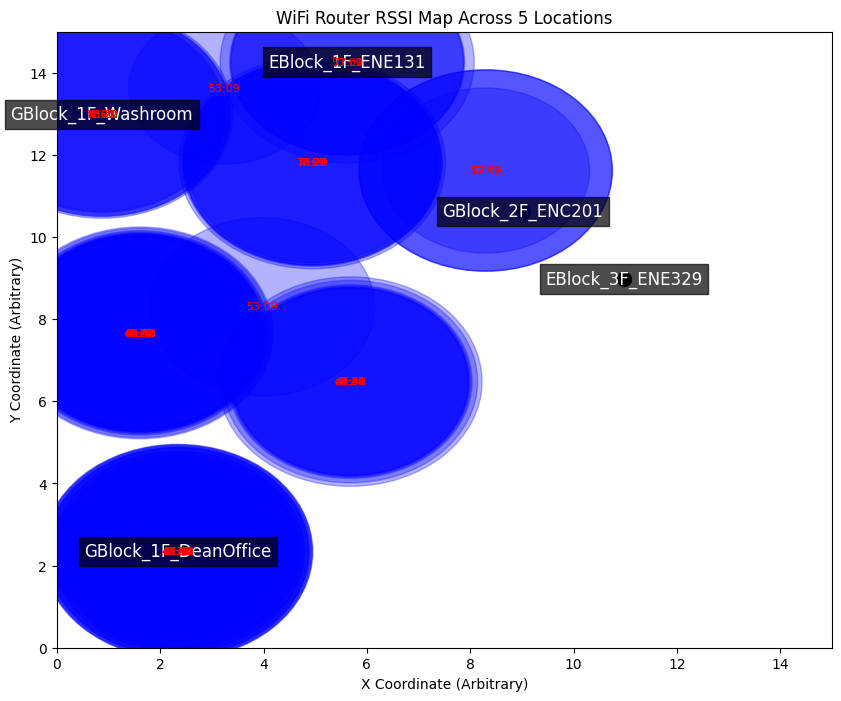

In [8]:
import numpy as np

# Compute average RSSI per router (MAC) at each location
avg_rssi_per_router = df.groupby(["Location", "MAC_Address"])["RSSI"].mean().reset_index()

# Normalize RSSI for circle size (smaller RSSI = larger circle)
avg_rssi_per_router["Circle_Size"] = abs(avg_rssi_per_router["RSSI"]) * 1.5  # Adjust scale factor to reduce overlap

# Get unique locations
locations = avg_rssi_per_router["Location"].unique()

# Assign random positions for locations (simulating a spatial map)
np.random.seed(42)  # Fix random seed for reproducibility
location_positions = {loc: (np.random.rand() * 15, np.random.rand() * 15) for loc in locations}  # Increase spread

# Filter only routers appearing in more than 1 location
shared_macs = avg_rssi_per_router.groupby("MAC_Address")["Location"].nunique()
shared_macs = shared_macs[shared_macs > 1].index  # Keep only routers appearing in more than 1 location
filtered_rssi_per_router = avg_rssi_per_router[avg_rssi_per_router["MAC_Address"].isin(shared_macs)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot location points
for loc, (x, y) in location_positions.items():
    ax.scatter(x, y, color='black', label=loc, s=100)
    ax.text(x, y, loc, fontsize=12, ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.7))

# Dictionary to store plotted routers
router_positions = {}

# Plot circles for routers (MACs)
for _, row in filtered_rssi_per_router.iterrows():
    loc, mac, rssi, size = row["Location"], row["MAC_Address"], row["RSSI"], row["Circle_Size"]
    x, y = location_positions[loc]

    if mac in router_positions:
        # If the router exists, place the circle between shared locations
        prev_x, prev_y = router_positions[mac]
        new_x, new_y = (prev_x + x) / 2, (prev_y + y) / 2  # Midpoint
    else:
        # If the router is new, place it at the first location
        new_x, new_y = x, y
        router_positions[mac] = (new_x, new_y)

    # Draw the circle for the router at this location
    circle = plt.Circle((new_x, new_y), size / 50, color='blue', alpha=0.3, label=mac)
    ax.add_patch(circle)
    ax.text(new_x, new_y, mac[-5:], fontsize=8, ha='center', va='center', color='red')

# Adjust plot
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_xlabel("X Coordinate (Arbitrary)")
ax.set_ylabel("Y Coordinate (Arbitrary)")
ax.set_title("WiFi Router RSSI Map Across 5 Locations")

plt.show()
